In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Functions

In [2]:
def select_indices_percent(data, train_frac=0.75, shuffle=True):
    '''
    Splits the dataset indices into training (default: 75%) and testing (default: 25%) sets.

    Parameters:
    data (pd.DataFrame): the dataset to be split
    train_frac (float): the fraction of rows to be used for training (default 0.75)
    shuffle (bool): whether the indices should be shuffled before splitting (default True)

    Returns:
    list: indices of training set
    list: indices of testing set
    '''
    
    indices = np.arange(len(data))
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    
    split = int(len(indices) * train_frac)
    train_indices = indices[:split]
    test_indices = indices[split:]
    return train_indices, test_indices


def select_indices_station(data, train_station, test_station):
    '''
    Splits the dataset indices into training and testing sets, so that the training and 
    testing sets consist only of the data for the specified stations.
    
    Parameters:
    data (pd.DataFrame): the dataset to be split
    train_station (str): abbreviation of station to be used for training
    test_station (str): abbreviation of station to be used for testing
    
    Returns:
    np.array: indices of training set
    np.array: indices of testing set
    '''
    
    train_indices = np.array(data.loc[data.station == train_station].index)
    test_indices = np.array(data.loc[data.station == test_station].index)
    return train_indices, test_indices


def make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100=False, print_shapes=False):
    '''
    Creates the training and testing sets 
    
    Parameters:
    data (pd.DataFrame): the dataset to create training and testing sets from
    predictors (list): list of predictors to be used
    train_indices (list or np.array):  indices of the training set
    test_indices (list or np.array):  indices of the testing set
    log_transf_n100 (bool): whether the n100 values should be log transformed (default False)
    print_shapes (bool): whether the shapes of the sets should be printed (default False)
    
    Returns:
    np.array: the data to train the model on
    np.array: the data to test the model on
    np.array: the n100 values to train the model on
    np.array: the n100 values to test the model on
    np.array: the log-transformed training set of n100 values
    np.array: the non-transformed n100 data
    '''
    
    # predictor variables (X)
    X_train = np.array(np.take(data[predictors], train_indices, 0))
    X_test = np.array(np.take(data[predictors], test_indices, 0))

    # n100 concentration (y)
    y_train = None
    y_test = None
    log_y_test = np.array(np.take(data.n100_log, test_indices, 0))
    orig_y_test = np.array(np.take(data.n100, test_indices, 0))
    
    # log-transforming the n100 values if specified
    if not log_transf_n100:
        y_train = np.array(np.take(data.n100, train_indices, 0))
        y_test = orig_y_test
    else:
        y_train = np.array(np.take(data.n100_log, train_indices, 0))
        y_test = log_y_test
    
    # printing the shapes of the training and test sets if specified
    if print_shapes:
        print('Train set shapes:', X_train.shape, 'and', y_train.shape)
        print('Test set shapes:', X_test.shape, 'and', y_test.shape)
        
    return X_train, X_test, y_train, y_test, log_y_test, orig_y_test


def get_corr(a, b, pr=3):
    '''
    Calculates Pearson's correlation between two variables and formats it as a string.
    
    Parameters:
    a (list or np.array): the first variable
    b (list or np.array): the second variable
    pr (int): the precision to be used for the calculated correlation (default 3)
    
    Returns:
    str: the correlation between a and b
    '''
    
    corr = pearsonr(a, b)[0]
    corr = np.round(corr, pr)
    return str(corr)


def eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=False):
    '''
    Calculates R^2, RMSE, and RMSLE to evaluate the model performance.
    
    Parameters:
    predictions (list or np.array): the predicted n100 values for the test set
    log_predictions (list or np.array): the log-transformed predicted n100 values for the test set 
    orig_y_test (list or np.array): the non-transformed test set of n100 values
    log_y_test (list or np.array): the log-transformed test set of n100 values
    print_results (bool): whether the results should be printed (default False)
    
    Returns:
    float: R^2 of the non-transformed test set n100 values
    float: R^2 of the log-transformed test set n100 values
    float: RMSLE of the non-transformed test set 
    float: RMSE of the log-transformed test set
    '''
    
    r2 = np.round(r2_score(orig_y_test, predictions), 4)
    r2_log = np.round(r2_score(log_y_test, log_predictions), 4)
    rmsle = np.round(np.sqrt(mean_squared_log_error(orig_y_test, predictions)), 4)
    rmse_log = np.round(np.sqrt(mean_squared_error(log_y_test, log_predictions)), 4)
    
    if print_results:
        print('R2 value on test set: %f' % r2)
        print('R2 value on test set (log-transformed): %f' % r2_log)
        print('RMSLE on test set: %f' % rmsle)
        print('RMSE on test set (log_transformed): %f' % rmse_log)
        
    return r2, r2_log, rmsle, rmse_log


def print_equation(model, predictors, pr=3):
    '''
    Prints the equation created by the linear regression model.
    
    Parameters:
    model (LinearRegression): the trained linear regression model
    predictors (list): list of predictors that were used to train the model
    pr (int): the precision to be used for the calculated correlation (default 3)
    
    Returns:
    str: the formatted equation
    '''
    
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    equation = 'Model equation:\n' 
    equation += 'n100 =' if not log_transf_n100 else 'n100_log ='
    
    # adding the coefficients one after another
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + predictors[i]
    
    # adding the intercept
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
        
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

    
def corr_eval(predictions, observations, log_transf=False, station=None):
    '''
    Plots the observed and predicted n100 concentrations against each other.
    
    Parameters:
    predictions (list or np.array): the predicted n100 values
    observations (list or np.array): the observed n100 values
    log_transf (bool): whether the n100 values were log-transformed (default False)
    station (str): if only data from one station was used the name can be specified (default None)
    
    Returns:
    None
    '''
    
    corr = get_corr(observations, predictions)
    axis_min = max(0, min(observations.min(), predictions.min()) - 0.5)
    axis_max = max(observations.max(), predictions.max()) + 0.5
    
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(axis_min, axis_max+1), np.arange(axis_min, axis_max+1), c='black', alpha=0.25)
    plt.scatter(observations, predictions, s=2, alpha=0.5)
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    title = 'Observed vs. Predicted n100 Concentration'
    output = 'Correlation between observed and predicted n100 concentration'
    
    if log_transf:
        title += ' (log-transformed)'
        output += ' (log-transformed)'
        
    if station != None:
        title += ' - ' + station
        
    plt.title(title)
    print(output + ': ' + corr)
    

def plot_results(name, predictions, observations):
    '''
    Plots the observed and predicted n100 concentrations on a log-scale.
    
    Parameters:
    name (str): name of the model
    predictions (list or np.array): the predicted n100 values
    observations (list or np.array): the observed n100 values
    
    Returns:
    None
    '''
    
    plt.figure(figsize=(10, 5))
    plt.title('Performance of ' + name + ' Model')
    plt.plot(observations, label='Observed', lw=0.5)
    plt.plot(predictions, label='Predicted', alpha=0.75, lw=0.5)
    plt.xlabel('Observation')
    plt.ylabel('n100 Concentration (log-transformed)')
    plt.ylim(0, 12)
    plt.legend()
    

def plot_residuals(name, predictions, observations):
    '''
    Plots the distribution of residuals (in log-scale) to check if errors are normally distributed.
    
    Parameters:
    name (str): name of the model
    predictions (list or np.array): the predicted n100 values
    observations (list or np.array): the observed n100 values
    
    Returns:
    None
    '''
    
    plt.figure(figsize=(6, 4))
    plt.title('Residual of Predictions for ' + name + ' Model')
    plt.hist(observations - predictions, bins=200)
    plt.ylabel('Frequency')
    plt.xlabel('Residual')
    plt.xlim(-10, 10)

# Data

In [3]:
# the measurement station codes (35 stations)
# more detailed information on the stations can be found in metadata/measurement_sites_info.txt
stations = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
            'FKL', 'HAD', 'HEL', 'HPB', 'HRW', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 
            'MLP', 'MUK', 'NAN', 'NEU', 'POV', 'PRL', 'SAO', 'SCH', 'SGP', 'UAE',
            'VAR', 'VHL', 'VIE', 'WAL', 'ZOT']

# list of all variables
# a full description of all variable names can be found in metadata/variable_names.txt
variables = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
             'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11', 'co', 'c5h8', 'c10h16', 
             'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 'crwc', 'blh', 'rh', 'wind_speed',
             'doy_sin', 'doy_cos', 'latitude', 'longitude']

# list of variables that should NOT be log-transformed
dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude']

# list of all variables
all_vars = ['aermr01', 'aermr02', 'aermr03',
            'aermr01_log', 'aermr02_log', 'aermr03_log',
            'aermr04', 'aermr05', 'aermr06',
            'aermr04_log', 'aermr05_log', 'aermr06_log',
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11',
            'aermr07_log', 'aermr08_log', 'aermr09_log', 'aermr10_log', 'aermr11_log',
            'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 
            'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log',
            'd2m', 't2m', 'blh', 'rh', 'wind_speed', 'wind_speed_log', 'crwc', 'crwc_log']

# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed n100 values that are < 1 become negative, so they are set to 1
data.loc[data.n100 < 1, 'n100'] = 1

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in ['n100']+variables:
    if v not in dont_transform:
        data[v+'_log'] = np.log(data[v].where(data[v] > 0, data[v][data[v] > 0].min()))
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude,n100,aermr01,aermr02,...,aermr11_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log,wind_speed_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,50.57,12.99,2708.085714,6.752697e-12,5.765684e-10,...,-21.085343,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861,0.206111
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,50.57,12.99,2489.175000,4.223335e-12,3.600730e-10,...,-21.136839,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861,-0.038023
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,50.57,12.99,3484.229167,3.553853e-12,3.007895e-10,...,-20.573239,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861,-0.240990
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,50.57,12.99,2977.512500,8.665312e-12,7.307493e-10,...,-19.603823,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861,0.558898
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,50.57,12.99,2702.463636,1.436837e-11,1.208825e-09,...,-19.666249,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861,0.726787


In [4]:
# ----------------------------------------------------------------------
# OLD CODE - use if only 1 year of data should be used from each station
# ----------------------------------------------------------------------

# selecting 1 year of data from each station based on the start and end dates 
# specified in metadata/date_ranges_of_stations.csv
# date_ranges = pd.read_csv('metadata/date_ranges_of_stations.csv', 
#                           parse_dates=['start_date', 'end_date'], dayfirst=True)

# new_data = []
# for s in stations:
#     sd = date_ranges.start_date.loc[date_ranges.station == s].iloc[0]
#     ed = date_ranges.end_date.loc[date_ranges.station == s].iloc[0]
#     s_data = data.loc[data.station == s]
#     s_data = s_data.loc[s_data.date >= sd]
#     s_data = s_data.loc[s_data.date <= ed]
#     new_data.append(s_data)

# new_data = pd.concat(new_data)
# new_data = new_data.reset_index(drop=True)

# plt.hist(data.date, bins=100, label='old dataset')
# plt.hist(new_data.date, bins=100, label='new dataset')
# plt.title('Distributions of dates')
# plt.legend()

# data = new_data

# Parameter selection

In [5]:
# lists of different predictor combinations to run models with

# a) aerosol data
predictors_a = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                'aermr10_log', 'aermr11_log']

# b1) gas and meteorological data, including slow-access data
predictors_b1 = ['co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 'no_log', 'no2_log', 'so2_log', 
                 't2m', 'blh', 'rh', 'wind_speed_log', 'crwc_log']

# b2) gas and meteorological data, excluding slow-access data
predictors_b2 = ['co_log', 'c5h8_log', 'no_log', 'no2_log', 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log']

# c1) all data, including slow-access data
predictors_c1 = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                 'aermr10_log', 'aermr11_log', 'co_log', 'c5h8_log', 'c10h16_log', 'nh3_log', 
                 'no_log', 'no2_log', 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log', 'crwc_log']

# c2) all data, excluding slow-access data
predictors_c2 = ['aermr01_log', 'aermr04_log', 'aermr07_log', 'aermr08_log', 'aermr09_log', 
                 'aermr10_log', 'aermr11_log', 'co_log', 'c5h8_log', 'no_log', 'no2_log', 
                 'so2_log', 't2m', 'blh', 'rh', 'wind_speed_log']

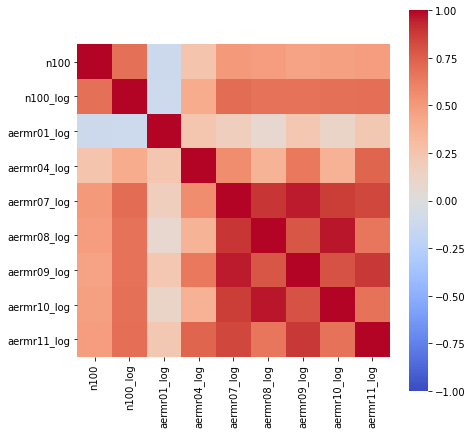

In [6]:
# SELECT which list of predictors should be used
predictors = predictors_a
# ----------------------------------------------------------------------

# plotting the correlation between n100 and the selected predictors
corr = data[['n100', 'n100_log']+predictors].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr, xticklabels=['n100', 'n100_log']+predictors, yticklabels=['n100', 'n100_log']+predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1);

# Linear Regression

## Approach 1

Training LR models on one station at a time and testing on all stations (including the one the model was trained on) individually. Plotting the R^2 and RMSE values for each pair (training station, testing station) as a heatmap to see if there are any patterns in stations that produce good proxies for each other.

In [7]:
# SELECT whether n100 should be log-transformed
log_transf_n100 = True

# SELECT which list of predictors should be used
predictors = predictors_a
# ----------------------------------------------------------------------

# training the model using data for one station and testing the model on data of one other station
# the model prints the station name that it's currently training models on
r2_log_all, rmse_log_all, log_predictions_all = [], [], []
for train_station in stations:
    print(train_station)
    r2_log_ts, rmse_log_ts, log_predictions_ts = [], [], []
    
    for test_station in stations:
        # creating the train and test sets
        train_indices, test_indices = select_indices_station(data, train_station, test_station)
        tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
        X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

        # fitting the linear regression model
        model = LinearRegression().fit(X_train, y_train)

        # making the test set predictions
        predictions = model.predict(X_test)
        log_predictions = None
        if log_transf_n100:
            predictions[predictions <= 0] = 0
            log_predictions = predictions
            predictions = np.exp(predictions)
            predictions[predictions <= 1] = 1
        else:
            predictions[predictions <= 1] = 1
            log_predictions = np.log(predictions)

        # evaluating the model performance
        r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test)
        r2_log_ts.append(r2_log)
        rmse_log_ts.append(rmse_log)
        log_predictions_ts.append(log_predictions)
        
    r2_log_all.append(r2_log_ts)
    rmse_log_all.append(rmse_log_ts)
    log_predictions_all.append(log_predictions_ts)

r2_log_all = np.array(r2_log_all)
rmse_log_all = np.array(rmse_log_all)
log_predictions_all = np.array(log_predictions_all)

ABZ
ALE
AMA
AMM
ASP
BEI
BOT
BSL
DEL
EGB
FKL
HAD
HEL
HPB
HRW
HYY
KCE
KPZ
MAR
MHD
MLP
MUK
NAN
NEU
POV
PRL
SAO
SCH
SGP
UAE
VAR
VHL
VIE
WAL
ZOT


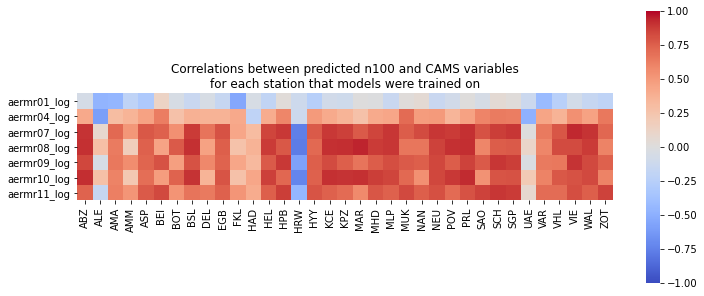

In [8]:
# calculating the correlation between the predicted n100 values and the values of each of the predictors
pred_n100_corrs = []
for i in range(len(stations)):
    test_data = data[predictors]
    test_data.insert(0, 'predicted_n100', np.concatenate(log_predictions_all[i]))
    pred_n100_corrs.append(test_data.corr()['predicted_n100'].iloc[1:])

plt.figure(figsize=(12, 5))        
sns.heatmap(np.array(pred_n100_corrs).T, xticklabels=stations, yticklabels=predictors, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between predicted n100 and CAMS variables\nfor each station that models were trained on');

In [9]:
# rearranging the stations to reveal potential patterns in the two heatmap below
stations_rea = ['BOT', 'MAR', 'UAE', 'HPB', 'VIE', 'AMM', 'ZOT', 'SGP', 'VAR', 
                'EGB', 'MUK', 'BEI', 'SCH', 'HYY', 'MHD', 'ASP', 'VHL', 'HEL', 
                'NEU', 'WAL', 'SAO', 'MLP', 'KCE', 'KPZ', 'POV', 'ABZ', 'BSL', 
                'DEL', 'PRL', 'AMA', 'NAN', 'HAD', 'FKL', 'HRW', 'ALE']

r2_rearranged = []
for s1 in stations_rea:
    r2_rea = []
    for s2 in stations_rea:
        r2_rea.append(r2_log_all[stations.index(s1), stations.index(s2)])
    r2_rearranged.append(r2_rea)
    
rmse_rearranged = []
for s1 in stations_rea:
    rmse_rea = []
    for s2 in stations_rea:
        rmse_rea.append(rmse_log_all[stations.index(s1), stations.index(s2)])
    rmse_rearranged.append(rmse_rea)

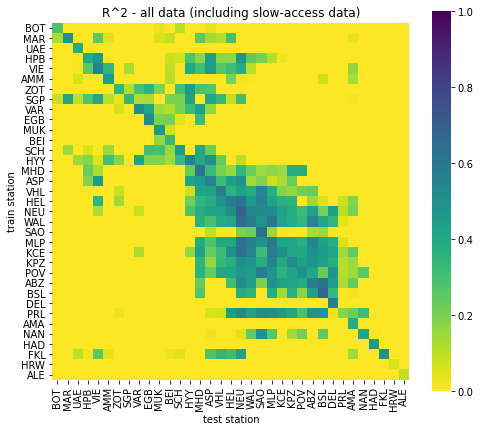

In [10]:
plt.figure(figsize=(8, 7))
sns.heatmap(r2_rearranged, xticklabels=stations_rea, yticklabels=stations_rea, 
            cmap='viridis_r', cbar=True, square=True, vmin=0, vmax=1)
plt.xlabel('test station')
plt.ylabel('train station')
plt.title('R^2 - all data (including slow-access data)');

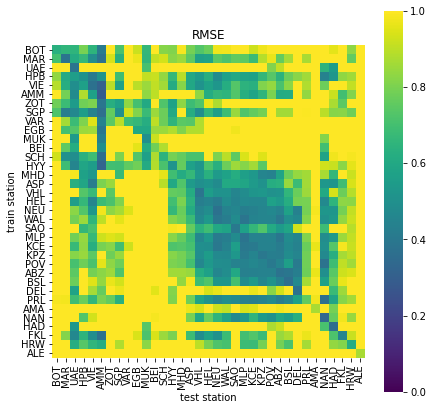

In [11]:
plt.figure(figsize=(7, 7))
sns.heatmap(rmse_rearranged, xticklabels=stations_rea, yticklabels=stations_rea, 
            cmap='viridis', cbar=True, square=True, vmin=0, vmax=1)
plt.xlabel('test station')
plt.ylabel('train station')
plt.title('RMSE');

## Approach 2

LR model that uses 50% of all data (not shuffled, so that about half of the stations are used) for training and tests the model performance on the remaining 50%.

Model equation:
n100_log = 0.0*aermr01_log + 0.0*aermr04_log + 0.0*aermr07_log + 0.219*aermr08_log + 0.0*aermr09_log + 0.008*aermr10_log + 0.286*aermr11_log + 17.087

Correlation between observed and predicted n100 concentration: 0.766
Correlation between observed and predicted n100 concentration (log-transformed): 0.783
R2 value on test set: 0.489100
R2 value on test set (log-transformed): 0.551700
RMSLE on test set: 0.823400
RMSE on test set (log_transformed): 0.831200


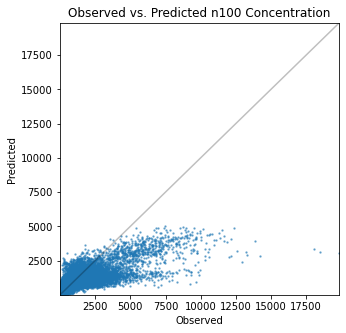

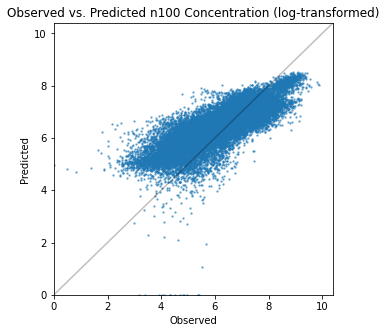

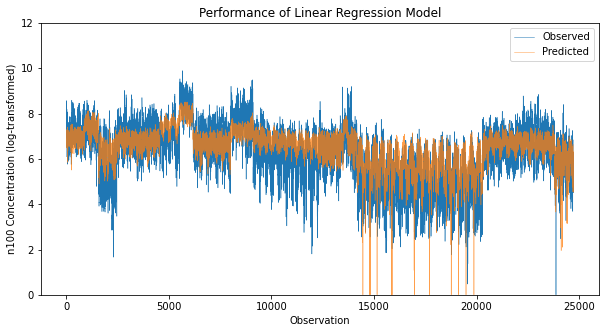

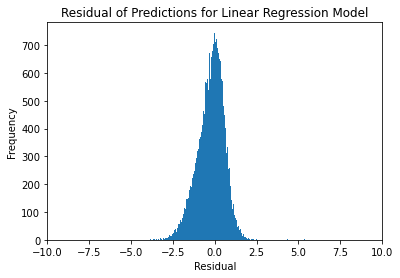

In [12]:
# SELECT whether n100 should be log-transformed
log_transf_n100 = True

# SELECT which list of predictors should be used
predictors = predictors_a
# ----------------------------------------------------------------------

train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# sklearn linear regression model using training set
model = LinearRegression(positive=True).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# printing the model evaluation
print_equation(model, predictors)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
r2, r2_log, rmsle, rmse_log = eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

# plotting the observed and predicted n100 concentrations against time in log-scale
plot_results('Linear Regression', log_predictions, log_y_test)
plot_residuals('Linear Regression', log_predictions, log_y_test)

# Random Forest Regression

RFR model that uses 50% of all data (not shuffled, so that about half of the stations are used) for training and tests the model performance on the remaining 50%.

Correlation between observed and predicted n100 concentration: 0.679
Correlation between observed and predicted n100 concentration (log-transformed): 0.797
R2 value on test set: 0.456800
R2 value on test set (log-transformed): 0.615600
RMSLE on test set: 0.764500
RMSE on test set (log_transformed): 0.769700


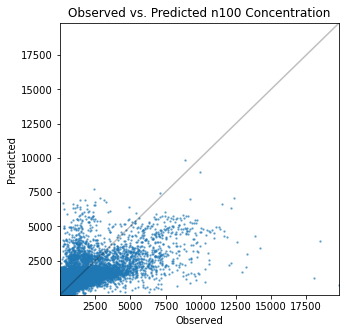

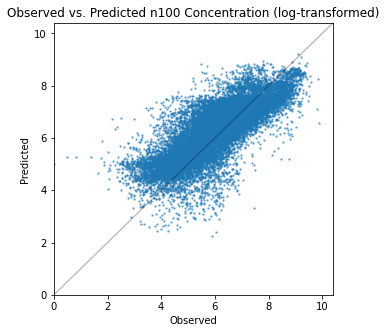

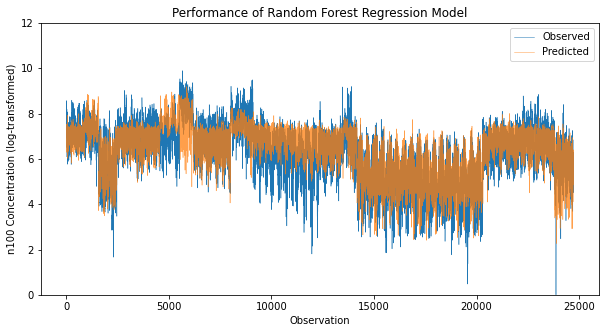

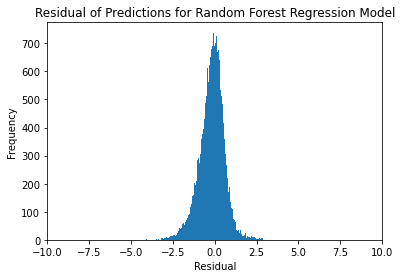

In [13]:
# SELECT whether n100 should be log-transformed
log_transf_n100 = True

# SELECT which list of predictors should be used
predictors = predictors_a
# ----------------------------------------------------------------------

train_indices, test_indices = select_indices_percent(data, train_frac=0.5, shuffle=False)
tr_te_sets = make_train_test_sets(data, predictors, train_indices, test_indices, log_transf_n100)
X_train, X_test, y_train, y_test, log_y_test, orig_y_test = tr_te_sets

# fitting the random forest regression model
model = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# making test set predictions
predictions = model.predict(X_test)
log_predictions = None
if log_transf_n100:
    predictions[predictions <= 0] = 0
    log_predictions = predictions
    predictions = np.exp(predictions)
    predictions[predictions <= 1] = 1
else:
    predictions[predictions <= 1] = 1
    log_predictions = np.log(predictions)

# plotting observed vs. predicted n100 concentrations
corr_eval(predictions, orig_y_test)
corr_eval(log_predictions, log_y_test, log_transf=True)

# evaluating the model performance
eval_model(predictions, log_predictions, orig_y_test, log_y_test, print_results=True)

# plotting the observed and predicted n100 concentrations against time
plot_results('Random Forest Regression', log_predictions, log_y_test)
plot_residuals('Random Forest Regression', log_predictions, log_y_test)